In [1]:
%matplotlib inline
import math
import os
import tarfile
import shutil
import hashlib
import glob
import random
import pickle
from datetime import datetime
from typing import *

from numba import jit
import requests
from joblib import Parallel, delayed

from PIL import Image, ImageOps
import numpy as np
from sklearn.metrics import *

import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
from PIL import Image, ImageDraw


from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectPercentile, f_classif
from tqdm import tqdm


In [2]:
dataset_path = 'dataset'

results_path = 'results'

if not os.path.exists(dataset_path):
    os.mkdir(dataset_path)

if not os.path.exists(results_path):
    os.mkdir(results_path)

In [3]:
def download_file(url: str, path: str):
    print('Downloading file ...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(path, 'wb') as f:
            r.raw.decode_content = True
            shutil.copyfileobj(r.raw, f)
    print('Downloading completed.')
    


def untar(file_path: str, dest_path: str):
    print('Extracting file.')
    with tarfile.open(file_path, 'r:gz') as f:
        f.extractall(dest_path)
    print('Extraction completed.')

In [4]:
faces_url = 'https://www.dropbox.com/s/ubjjoo0b2wz4vgz/faces_aligned_small_mirrored_co_aligned_cropped_cleaned.tar.gz?dl=1'


faces_archive = os.path.join(dataset_path, 'faces_aligned_small_mirrored_co_aligned_cropped_cleaned.tar.gz')
faces_dir = os.path.join(dataset_path, 'faces_aligned_small_mirrored_co_aligned_cropped_cleaned')

if not os.path.exists(faces_archive):
    download_file(faces_url, faces_archive)

In [5]:
if not os.path.exists(faces_dir):
    untar(faces_archive, dataset_path)

Extracting file.
Extraction completed.


In [6]:
face_image_files = glob.glob(os.path.join(faces_dir, '**', '*.png'), recursive=True)
print(len(face_image_files))

#Taking 2000 face images as our total number training and testing dataset images
face_image_files=face_image_files[:2000]

37921


In [7]:
Image_SIZE=22

def to_float_array(img: Image.Image) -> np.ndarray:
    return np.array(img).astype(np.float32) / 255.

def to_image_func(values: np.ndarray) -> Image.Image:
    return Image.fromarray(np.uint8(values * 255.))

def gamma_func(values: np.ndarray, coeff: float=2.2) -> np.ndarray:
    return values**(1./coeff)

def open_face(path: str, resize: bool=True) -> Image.Image:
    CROP= 50
    img = Image.open(path)
    img = to_image_func(gamma_func(to_float_array(img)[CROP:, :]))
    min_size = np.min(img.size)
    img = ImageOps.fit(img, (min_size, min_size), Image.ANTIALIAS)
    if resize:
        img = img.resize((Image_SIZE, Image_SIZE), Image.ANTIALIAS)
    return img.convert('L')

def gleam_func(values: np.ndarray) -> np.ndarray:
    return np.sum(gamma_func(values), axis=2) / values.shape[2]

In [8]:

face_images = [open_face(f) for f in face_image_files]

  

C:\Users\aksha\AppData\Local\Temp\ipykernel_8020\1710668849.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = ImageOps.fit(img, (min_size, min_size), Image.ANTIALIAS)
C:\Users\aksha\AppData\Local\Temp\ipykernel_8020\1710668849.py:19: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((Image_SIZE, Image_SIZE), Image.ANTIALIAS)


In [32]:
def getImages(all_images):
    images, nimages = [], []

    for im in all_images:
        images.append(im)

        img = normalize_image(im)
        nimages.append(im)

    images = np.stack(images, axis=0)
    nimages = np.stack(nimages, axis=0)

    return images, nimages


def normalize_image(img):
    img = np.array(img)
    mean = img.mean()
    std = img.std()
    
    img = (img - mean) / std 
    img = np.ndarray.tolist(img)
    return img

  


In [40]:
# faces, nfaces = getImages(face_images)
face_images_copy=face_images.copy()

def display_five(face_images_copy):
  k=1

  for i,img in enumerate(face_images_copy):
    display(img)
    img.save('plot'+str(i)+'.png')
    if i==5:
      break

random.seed(10)
# display_five(face_images_copy)
random.shuffle(face_images_copy)


# print ("   ")
# print ("   ")
display_five(face_images_copy)


In [11]:

train_faces=face_images_copy[:int(.8*len(face_images_copy))]
test_faces=face_images_copy[int(.8*len(face_images_copy)):]

# print (len(train_faces))
# print (len(test_faces))

In [12]:
backgrounds_url = 'http://dags.stanford.edu/data/iccv09Data.tar.gz'


backgrounds_archive = os.path.join(dataset_path, 'iccv09Data.tar.gz')
backgrounds_dir = os.path.join(dataset_path, 'iccv09Data')

if not os.path.exists(backgrounds_archive):
    download_file(backgrounds_url, backgrounds_archive)

In [13]:
if not os.path.exists(backgrounds_dir):
    untar(backgrounds_archive, dataset_path)

Extracting file.
Extraction completed.


In [14]:
background_image_files = glob.glob(os.path.join(backgrounds_dir, '**', '*.jpg'), recursive=True)
len(background_image_files)

715

In [15]:
Image_SIZE_2=40
Image_SIZE_1=22

def random_crop(img: Image.Image) -> Image.Image:
    max_allowed_size = np.min(img.size)
    size = random.randint(Image_SIZE_2, max_allowed_size)
    max_width = img.size[0] - size - 1
    max_height = img.size[1] - size - 1
    left = 0 if (max_width <= 1)  else random.randint(0, max_width)
    top  = 0 if (max_height <= 1) else random.randint(0, max_height)
    return img.crop((left,top,left+size,top+size))

def open_background(path: str, resize: bool=True) -> Image.Image:
    img = Image.open(path)
    img = to_image_func(gleam_func(to_float_array(img)))
    img = random_crop(img)
    if resize:
        img = img.resize((Image_SIZE_1, Image_SIZE_1), Image.ANTIALIAS)
    return img.convert('L')

In [16]:
# background_images=[]

# for i in range(8):
#   background_images=background_images+[open_background(f) for f in background_image_files]


background_images_1 = [open_background(f) for f in background_image_files]
background_images_2 = [open_background(f) for f in background_image_files]
# background_images_3 = [open_background(f) for f in background_image_files]
# background_images_4 = [open_background(f) for f in background_image_files]
# background_images_5 = [open_background(f) for f in background_image_files]
# background_images_6 = [open_background(f) for f in background_image_files]
# background_images_7 = [open_background(f) for f in background_image_files]
# background_images_8 = [open_background(f) for f in background_image_files]




C:\Users\aksha\AppData\Local\Temp\ipykernel_8020\431376589.py:18: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((Image_SIZE_1, Image_SIZE_1), Image.ANTIALIAS)


In [17]:
# background_images=background_images_1+background_images_2+background_images_3+background_images_4+\
# background_images_5+background_images_6+background_images_7+background_images_8

background_images=background_images_1+background_images_2

len(background_images)

1430

In [39]:
background_images_copy=background_images.copy()

random.seed(10)

random.shuffle(background_images_copy)
display_five(background_images_copy)

In [19]:
train_non_faces=background_images_copy[:int(.8*len(background_images_copy))]
test_non_faces=background_images_copy[int(.8*len(background_images_copy)):]

# print (len(train_non_faces))
# print (len(test_non_faces))

In [20]:
faces, nfaces = getImages(train_faces)

print("Number of faces in training data: ", len(faces))
nonfaces, nnonfaces = getImages(train_non_faces)
print("Number of non faces in training data: ", len(nonfaces))

Number of faces in training data:  1600
Number of non faces in training data:  1144


C:\Users\aksha\AppData\Local\Temp\ipykernel_8020\2549862657.py:21: RuntimeWarning: invalid value encountered in true_divide
  img = (img - mean) / std


In [22]:
_, testfaces = getImages(test_faces)
print("Number of faces in test data: ", len(testfaces))

_, testnonfaces = getImages(test_non_faces)
print("Number of non faces in test data: ", len(testnonfaces))


Number of faces in test data:  400
Number of non faces in test data:  286


In [23]:
data = np.array(nfaces.tolist()+ nnonfaces.tolist())
y = [1] * len(nfaces) + [0] * len(nnonfaces)

# random shuffle the data
trainingData = list(zip(data, y))
random.seed(10)
random.shuffle(trainingData)

In [24]:
test_data = np.array(testfaces.tolist() + testnonfaces.tolist())
test_y = [1] * len(testfaces) + [0] * len(testnonfaces)
testData = list(zip(test_data, test_y))

In [25]:
class Integral_Image:
    def __init__(self, image):
        self.image = image
        self.integral = self.create_integral_image(self.image)


    def create_integral_image(self, image):
        temp=np.cumsum(image, axis=0)
        integral_image = np.cumsum(temp, axis=1)
        integral_image=np.pad(integral_image, (1, 1), 'constant', constant_values=(0, 0))
        return integral_image[:-1, :-1]

    def compute_integral_area(self, Coordinates):
        positive_area=self.integral[Coordinates[0][0]][Coordinates[0][1]]  + self.integral[Coordinates[2][0]][Coordinates[2][1]] 
        negative_area= self.integral[Coordinates[1][0]][Coordinates[1][1]] + self.integral[Coordinates[3][0]][Coordinates[3][1]]
        integral_area=positive_area-negative_area
        return integral_area

In [26]:

Haar_features={}

Haar_features['Vertical_2_rectangle']=(1, 2)
Haar_features['Horizontal_2_rectangle']=(2,1)
Haar_features['Vertical_3_rectangle']=(3,1)
Haar_features['Horizontal_3_rectangle']=(1,3)
Haar_features['4_rectangles']=(2,2)

In [27]:

class Viola_Jones:
    def __init__(self, rounds=10):
        self.rounds = rounds
        self.classifiers = []
        self.alphas = []
   

    def create_Haar_features(self, size_of_window):
        features = []

        for feature_type in Haar_features.keys():
            temp_features = []
            feature=Haar_features[feature_type]
            for width in range(feature[0], size_of_window + 1, feature[0]):
                for height in range(feature[1], size_of_window + 1, feature[1]):
                    for x in range(0, size_of_window - width + 1):
                        for y in range(0, size_of_window - height + 1):
                            temp_features.append(Rectangular_Region(x, y, width, height, feature))
            print ("\n")
            print("Total features of type {} : {}".format(str(feature_type), len(temp_features)))
            features += temp_features
        print ("\n")
        print("Total calculated features: {}".format(len(features)))
        
        return np.array(features)



    def train(self, trainingData):
        data, y = zip(*trainingData)
        number_of_faces = np.sum(y) 

        number_of_nonfaces =len(y) - np.sum(y)

        weights = np.zeros(len(y), dtype=np.float32)
        weights[np.array(y) == 1] = 1. / (2. * number_of_faces)
        weights[np.array(y) == 0] = 1. / (2. * number_of_nonfaces)

        print ("\n")
        print("Creating the integral images..")
        
        Integral_Images = list(map(lambda x: Integral_Image(x), data))
        print ("\n")
        print("Creating the integral images done")
        print ("\n")
        print("Creating the Haar features")
        print ("\n")
        features = self.create_Haar_features(data[0].shape[0])
        
        print("Applying the created Haar features")
        print ("\n")
        X = np.zeros((len(features), len(Integral_Images)))
        for i in tqdm(range(len(features))):
            X[i] = list(map(lambda x: features[i].computeFeature(x), Integral_Images))


        indices = SelectPercentile(f_classif, percentile=10).fit(X.T, y).get_support(indices=True)
        X = X[indices]
        features = features[indices]

        for t in range(self.rounds):
            print ("\n")
            print("Training Weak Classifier Round number: " + str(t + 1))
            weights = weights / np.sum(weights)
        

            positive_total = np.sum(weights[np.where(y == 1)])
            negative_total = np.sum(weights[np.where(y == 0)])

            weak_classifiers = []
            for index, feature in enumerate(X):
                applied_feature = sorted(zip(weights, feature, y), key=lambda x: x[1])

                seen_positive, seen_negative = 0, 0
                positive_weights, negative_weights = 0, 0
                minimum_error, best_feature, best_threshold, best_polarity = float('inf'), None, None, None
                for w, f, label in applied_feature:
                    error = min(negative_weights + positive_total - positive_weights,
                                positive_weights + negative_total - negative_weights)

                    if error < minimum_error:
                        minimum_error = error
                        best_feature = features[index]
                        best_threshold = f
                        best_polarity = 1 if seen_positive > seen_negative else -1

                    if label == 1:
                        seen_positive += 1
                        positive_weights += w
                    else:
                        seen_negative += 1
                        negative_weights += w
                    
                classifier = Classifier(best_feature, best_threshold, best_polarity)
                weak_classifiers.append(classifier)


            best_classifier, best_error, best_accuracy = None, float('inf'), None
            for classifier in tqdm(weak_classifiers):
                error, accuracy = 0, []
                for data, label, w in zip(Integral_Images, y, weights):
                    classify = classifier.classify(data)
                    correctness = np.abs(classify - label)
                    accuracy.append(correctness)
                    error += w * correctness
                    
                error = error / len(Integral_Images)
                
                if error < best_error:
                    best_classifier, best_error, best_accuracy = classifier, error, accuracy


            classifier, error, accuracy = best_classifier, best_error, best_accuracy
        
            beta = error / (1.0 - error)
            for i in range(len(accuracy)):
                weights[i] = weights[i] * math.pow(beta, 1 - accuracy[i])

            alpha = np.log(1.0 / (beta + 1e-18))
            self.alphas.append(alpha)
            self.classifiers.append(classifier)
       
            print("{}, \nerror: {}, \nalpha: {}".format(classifier, error, alpha))

        return self.classifiers, self.alphas





    def classify(self, image, alphas=None, classifiers=None, threshold=0.5):
        total = 0
       
        if alphas is None and classifiers is None:
            alphas = self.alphas
            classifiers = self.classifiers

        for alpha, classifier in zip(alphas, classifiers):
            classify = classifier.classify(image)
            total += alpha * classify

        return 1 if total >= threshold * sum(alphas) else 0


    def evaluate(self, data, rounds, threshold=0.5, print_details=False):
        X, y = zip(*data)
        Integral_Images = list(map(lambda x: Integral_Image(x), X))
        
        true_negatives, false_negatives = 0, 0
        true_positives, false_positives = 0, 0

        for index, label in enumerate(y):
            prediction = self.classify(Integral_Images[index], alphas=self.alphas[:rounds], classifiers=self.classifiers[:rounds], threshold=threshold)

            if label == prediction:
                if prediction == 1:
                    true_positives += 1
                else:
                    true_negatives += 1
            else:
                if prediction == 1:
                    false_positives += 1
                else:
                    false_negatives += 1

        accuracy = (true_positives + true_negatives) / (true_positives + false_negatives + true_negatives + false_positives)
        true_positive_rate = true_positives / (true_positives + false_negatives)
        false_positive_rate = false_positives / (false_positives + true_negatives)

        if print_details:
            print("\nFor Round number {}, we get: \nthreshold = {},".format(rounds,threshold))
            print ("Accuracy = {:.4%} ({}/{}),".format(accuracy,true_positives + true_negatives,true_positives + false_negatives + true_negatives + false_positives))
            print ("False Positive = {:.4%} ({}/{}),".format(false_positives / (true_positives + false_negatives + true_negatives + false_positives),false_positives,
                                                                            true_positives + false_negatives + true_negatives + false_positives,))
            print ("False Negative = {:.4%} ({}/{})".format(false_negatives / (true_positives + false_negatives + true_negatives + false_positives),
                                                                            false_negatives,
                                                                            true_positives + false_negatives + true_negatives + false_positives))

        return true_positive_rate, false_positive_rate 

In [28]:

class Classifier:
    def __init__(self, feature, threshold, polarity):
        self.feature = feature
        self.threshold = threshold
        self.polarity = polarity

        if self.feature.type_of_feature==(1, 2):
          self.feature_name='Vertical_2_rectangle'
        if self.feature.type_of_feature==(2,1):
          self.feature_name='Horizontal_2_rectangle'
        if self.feature.type_of_feature==(3,1):
          self.feature_name='Vertical_3_rectangle'

        if self.feature.type_of_feature==(1,3):
          self.feature_name='Horizontal_3_rectangle'
        if self.feature.type_of_feature==(2,2):
          self.feature_name='4_rectangles'
    


    def __repr__(self):
        return f'Selected classifier details : \nfeature: {self.feature_name},{self.feature}, \nthreshold={self.threshold}, \npolarity={self.polarity}'

    def classify(self, integral):
        feature_value = self.feature.computeFeature(integral)
        return 1 if self.polarity * feature_value < self.polarity * self.threshold else 0

    def draw(self, image):
        return self.feature.draw(image)

In [29]:

class Rectangular_Region:
    def __init__(self, x, y, width, height, type_of_feature):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
        self.type_of_feature = type_of_feature

    def __repr__(self):
        return f' Feature details: {self.type_of_feature}, x={self.x}, y={self.y}, width={self.width}, height={self.height}'



    def draw(self, image):
        image = Image.fromarray(image).convert('RGBA')
        drawing = ImageDraw.Draw(image)
        if self.type_of_feature == Haar_features['Horizontal_2_rectangle']:
            drawing.rectangle(((self.y, self.x), (self.y + self.height, self.x + self.width // 2)), fill = "white")
            drawing.rectangle(((self.y, self.x + self.width // 2), (self.y + self.height, self.x + self.width)), fill = "black")

        elif self.type_of_feature == Haar_features['Vertical_2_rectangle']:
            drawing.rectangle(((self.y, self.x), (self.y + self.height // 2, self.x + self.width)), fill = "black")
            drawing.rectangle(((self.y + self.height // 2, self.x), (self.y + self.height, self.x + self.width)), fill = "white")

        elif self.type_of_feature == Haar_features['Horizontal_3_rectangle']:
            drawing.rectangle(((self.y, self.x), (self.y + self.height, self.x + self.width // 3)), fill = "black")
            drawing.rectangle(((self.y, self.x + self.width // 3), (self.y + self.height, self.x + (2 * self.width) // 3)), fill = "white")
            drawing.rectangle(((self.y, self.x + (2 * self.width) // 3), (self.y + self.height, self.x + self.width)), fill = "black")


        elif self.type_of_feature == Haar_features['Vertical_3_rectangle']:
            drawing.rectangle(((self.y, self.x), (self.y + self.height // 3, self.x + self.width)), fill = "black")
            drawing.rectangle(((self.y + self.height // 3, self.x), (self.y + (2 * self.height) // 3, self.x + self.width)), fill = "white")
            drawing.rectangle(((self.y + (2 * self.height) // 3, self.x), (self.y + self.height, self.x + self.width)), fill = "black")

        elif self.type_of_feature == Haar_features['4_rectangles']:
            drawing.rectangle(((self.y, self.x), (self.y + self.height // 2, self.x + self.width // 2)), fill = "white")
            drawing.rectangle(((self.y, self.x + self.width // 2), (self.y + self.height // 2, self.x + self.width)), fill = "black")
            drawing.rectangle(((self.y + self.height // 2, self.x + self.width // 2), (self.y + self.height, self.x + self.width)), fill = "white")
            drawing.rectangle(((self.y + self.height // 2, self.x), (self.y + self.height, self.x + self.width // 2)), fill = "black")

        image = image.resize((300, 300))
        return image

    def computeFeature(self, integral):
        if self.type_of_feature == Haar_features['Horizontal_2_rectangle']:
            return integral.compute_integral_area([(self.y, self.x),
                           (self.y, self.x + self.width // 2),
                           (self.y + self.height, self.x + self.width // 2),
                           (self.y + self.height, self.x)]) \
                   - integral.compute_integral_area([(self.y, self.x + self.width // 2),
                            (self.y, self.x + self.width),
                            (self.y + self.height, self.x + self.width),
                            (self.y + self.height, self.x + self.width // 2)])

        elif self.type_of_feature == Haar_features['Vertical_2_rectangle']:

            return - integral.compute_integral_area([(self.y, self.x),
                           (self.y, self.x + self.width),
                           (self.y + self.height // 2, self.x + self.width),
                           (self.y + self.height // 2, self.x)]) \
                   + integral.compute_integral_area([(self.y + self.height // 2, self.x),
                            (self.y + self.height // 2, self.x + self.width),
                            (self.y + self.height, self.x + self.width),
                            (self.y + self.height, self.x)])

        elif self.type_of_feature == Haar_features['Horizontal_3_rectangle']:

            return - integral.compute_integral_area([(self.y, self.x),
                           (self.y, self.x + self.width // 3),
                           (self.y + self.height, self.x + self.width // 3),
                           (self.y + self.height, self.x)]) \
                   + integral.compute_integral_area( [(self.y, self.x + self.width // 3),
                            (self.y, self.x + (2 * self.width) // 3),
                            (self.y + self.height, self.x + (2 * self.width) // 3),
                            (self.y + self.height, self.x + self.width // 3)]) \
                   - integral.compute_integral_area([(self.y, self.x + (2 * self.width) // 3),
                           (self.y, self.x + self.width),
                           (self.y + self.height, self.x + self.width),
                           (self.y + self.height, self.x + (2 * self.width) // 3)])

        elif self.type_of_feature == Haar_features['Vertical_3_rectangle']:

            return - integral.compute_integral_area([(self.y, self.x),
                           (self.y, self.x + self.width),
                           (self.y + self.height // 3, self.x + self.width),
                           (self.y + self.height // 3, self.x)]) \
                   + integral.compute_integral_area([(self.y + self.height // 3, self.x),
                            (self.y + self.height // 3, self.x + self.width),
                            (self.y + (2 * self.height) // 3, self.x + self.width),
                            (self.y + (2 * self.height) // 3, self.x)]) \
                   - integral.compute_integral_area([(self.y + (2 * self.height) // 3, self.x),
                           (self.y + (2 * self.height) // 3, self.x + self.width),
                           (self.y + self.height, self.x + self.width),
                           (self.y + self.height, self.x)])

        elif self.type_of_feature == Haar_features['4_rectangles']:
            return integral.compute_integral_area([(self.y, self.x),
                           (self.y, self.x + self.width // 2),
                           (self.y + self.height // 2, self.x + self.width // 2),
                           (self.y + self.height // 2, self.x)]) \
                   - integral.compute_integral_area([(self.y, self.x + self.width // 2),
                            (self.y, self.x + self.width),
                            (self.y + self.height // 2, self.x + self.width),
                            (self.y + self.height // 2, self.x + self.width // 2)]) \
                   + integral.compute_integral_area([(self.y + self.height // 2, self.x + self.width // 2),
                           (self.y + self.height // 2, self.x + self.width),
                           (self.y + self.height, self.x + self.width),
                           (self.y + self.height, self.x + self.width // 2)]) \
                   - integral.compute_integral_area([(self.y + self.height // 2, self.x),
                            (self.y + self.height // 2, self.x + self.width // 2),
                            (self.y + self.height, self.x + self.width // 2),
                            (self.y + self.height, self.x)])



Creating the integral images..


Creating the integral images done


Creating the Haar features




Total features of type Vertical_2_rectangle : 30613


Total features of type Horizontal_2_rectangle : 30613


Total features of type Vertical_3_rectangle : 19481


Total features of type Horizontal_3_rectangle : 19481


Total features of type 4_rectangles : 14641


Total calculated features: 114829
Applying the created Haar features




100%|██████████████████████████████████████████████████████████████████████████| 114829/114829 [46:28<00:00, 41.18it/s]




Training Weak Classifier Round number: 1


100%|████████████████████████████████████████████████████████████████████████████| 11483/11483 [12:03<00:00, 15.88it/s]


Selected classifier details : 
feature: Vertical_3_rectangle, Feature details: (3, 1), x=5, y=3, width=12, height=8, 
threshold=-5601.0, 
polarity=1, 
error: 1.5708941773429335e-05, 
alpha: 11.061264758962098


Training Weak Classifier Round number: 2


100%|████████████████████████████████████████████████████████████████████████████| 11483/11483 [12:01<00:00, 15.91it/s]


Selected classifier details : 
feature: Horizontal_2_rectangle, Feature details: (2, 1), x=7, y=6, width=4, height=3, 
threshold=-95.0, 
polarity=1, 
error: 6.348839867615731e-06, 
alpha: 11.96723211090408


Training Weak Classifier Round number: 3


100%|████████████████████████████████████████████████████████████████████████████| 11483/11483 [12:03<00:00, 15.87it/s]


Selected classifier details : 
feature: Horizontal_2_rectangle, Feature details: (2, 1), x=0, y=2, width=8, height=16, 
threshold=-1868.0, 
polarity=1, 
error: 7.24751595879831e-08, 
alpha: 16.440021887679297


Training Weak Classifier Round number: 4


100%|████████████████████████████████████████████████████████████████████████████| 11483/11483 [11:47<00:00, 16.22it/s]


Selected classifier details : 
feature: Vertical_3_rectangle, Feature details: (3, 1), x=5, y=7, width=15, height=2, 
threshold=-122.0, 
polarity=1, 
error: 7.825902961555521e-10, 
alpha: 20.96841180366328


Training Weak Classifier Round number: 5


100%|████████████████████████████████████████████████████████████████████████████| 11483/11483 [12:24<00:00, 15.42it/s]


Selected classifier details : 
feature: Horizontal_2_rectangle, Feature details: (2, 1), x=14, y=1, width=8, height=16, 
threshold=2108.0, 
polarity=-1, 
error: 6.05414583759584e-08, 
alpha: 16.61993738362418


Training Weak Classifier Round number: 6


100%|████████████████████████████████████████████████████████████████████████████| 11483/11483 [12:27<00:00, 15.37it/s]


Selected classifier details : 
feature: 4_rectangles, Feature details: (2, 2), x=10, y=2, width=4, height=6, 
threshold=-56.0, 
polarity=1, 
error: 3.1584551452049543e-09, 
alpha: 19.573182803512083


Training Weak Classifier Round number: 7


100%|████████████████████████████████████████████████████████████████████████████| 11483/11483 [12:46<00:00, 14.99it/s]


Selected classifier details : 
feature: Horizontal_2_rectangle, Feature details: (2, 1), x=16, y=4, width=6, height=9, 
threshold=886.0, 
polarity=-1, 
error: 4.527327218388599e-07, 
alpha: 14.607963450873232


Training Weak Classifier Round number: 8


100%|████████████████████████████████████████████████████████████████████████████| 11483/11483 [12:51<00:00, 14.89it/s]


Selected classifier details : 
feature: Vertical_2_rectangle, Feature details: (1, 2), x=4, y=14, width=10, height=2, 
threshold=-70.0, 
polarity=1, 
error: 2.2152512143597095e-08, 
alpha: 17.625314909627797


Training Weak Classifier Round number: 9


100%|██████████████████████████████████████████████████████████████████████████| 11483/11483 [2:06:46<00:00,  1.51it/s]


Selected classifier details : 
feature: Vertical_2_rectangle, Feature details: (1, 2), x=3, y=6, width=2, height=4, 
threshold=8.0, 
polarity=-1, 
error: 3.6708683593017106e-09, 
alpha: 19.422837588760466


Training Weak Classifier Round number: 10


100%|██████████████████████████████████████████████████████████████████████████| 11483/11483 [1:41:29<00:00,  1.89it/s]


Selected classifier details : 
feature: Horizontal_2_rectangle, Feature details: (2, 1), x=11, y=1, width=10, height=3, 
threshold=582.0, 
polarity=-1, 
error: 1.5460440620934581e-09, 
alpha: 20.28756638428718

Evaluation for rounds: 1

Evaluation for rounds: 2

Evaluation for rounds: 3

Evaluation for rounds: 4

Evaluation for rounds: 5

Evaluation for rounds: 6

Evaluation for rounds: 7

Evaluation for rounds: 8

Evaluation for rounds: 9

Evaluation for rounds: 10

Evaluation metrics (for Training data):


For Round number 1, we get: 
threshold = 0.5,
Accuracy = 95.6268% (2624/2744),
False Positive = 1.6399% (45/2744),
False Negative = 2.7332% (75/2744)

For Round number 2, we get: 
threshold = 0.5,
Accuracy = 90.3061% (2478/2744),
False Positive = 6.5598% (180/2744),
False Negative = 3.1341% (86/2744)

For Round number 3, we get: 
threshold = 0.5,
Accuracy = 98.2507% (2696/2744),
False Positive = 0.2915% (8/2744),
False Negative = 1.4577% (40/2744)

For Round number 4, we get: 
thre

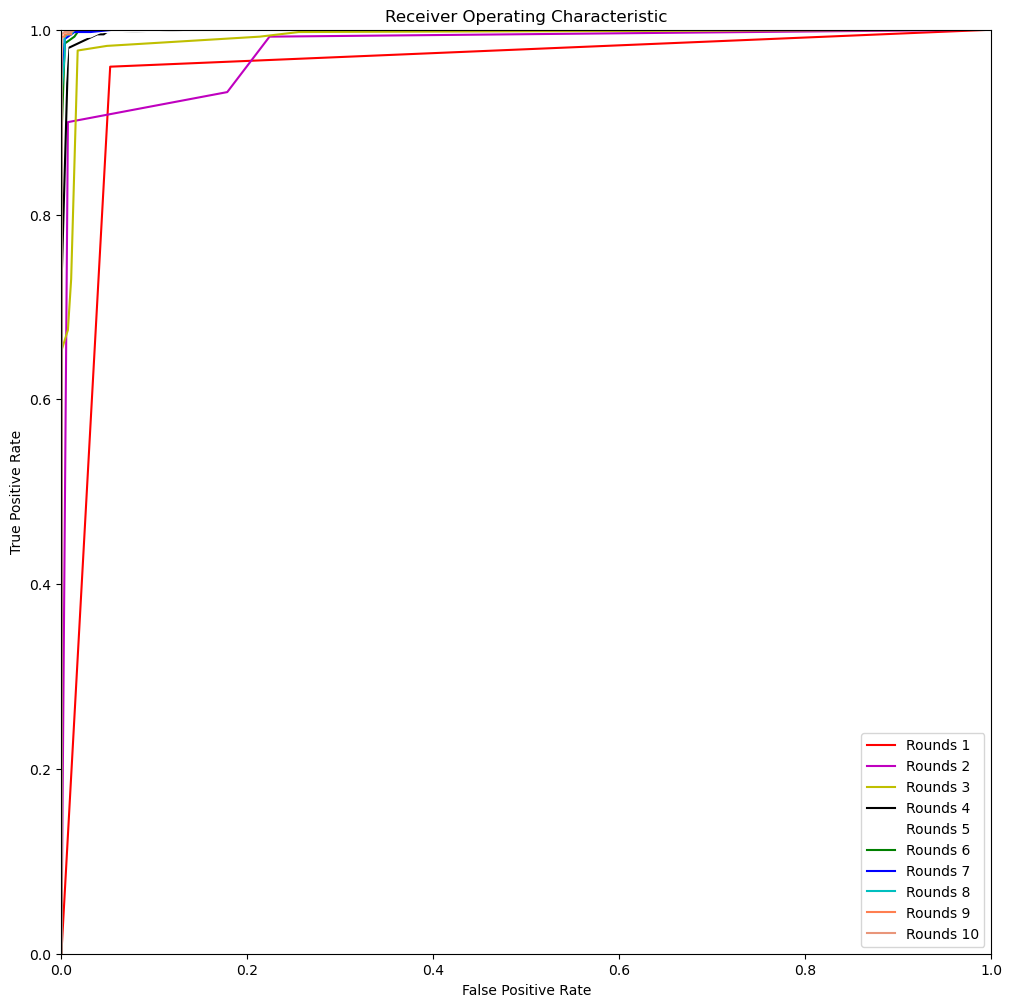

In [41]:

num_rounds = 10
Face_Detector = Viola_Jones(num_rounds)
classifiers, alphas = Face_Detector.train(trainingData)

with open('trained_model.pkl', 'wb') as handler:
    pickle.dump(Face_Detector, handler)

for index, classifier in enumerate(classifiers):
    image = classifier.draw(faces[0])
    image.save('results/' + 'round' + str(index + 1) + '.png')

# Plot ROC
plt.figure(figsize=(12, 12))
plt.title('Receiver Operating Characteristic')
plt.savefig('plot'+str(i)+'.png')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

colors = ['r', 'm', 'y' ,'k','w','g', 'b', 'c','coral','darksalmon']
rounds = [1,2,3,4,5,6,7,8,9,10]
for i in range(len(rounds)):
    print("\nEvaluation for rounds: {}".format(rounds[i]))
    true_positive_rates, false_positive_rates = [], []
    for threshold in np.arange(0, 1.01, 0.005):
        true_positive_rate, false_positive_rate = Face_Detector.evaluate(testData, rounds[i], threshold)
        true_positive_rates.append(true_positive_rate)
        false_positive_rates.append(false_positive_rate)

    plt.plot(false_positive_rates, true_positive_rates, colors[i], label="Rounds " + str(rounds[i]))

plt.legend(loc="lower right")
plt.savefig('results/roc.png')

print("\nEvaluation metrics (for Training data):\n")
for i in range(len(rounds)):
    Face_Detector.evaluate(trainingData, rounds[i], 0.5, print_details=True)

print("\nEvaluation metrics (for test data):\n")
for i in range(len(rounds)):
    Face_Detector.evaluate(testData, rounds[i], 0.5, print_details=True)

# New Section

# Cascade Classifier

In [ ]:

class CascadeClassifier():
    def __init__(self, layers):
        self.layers = layers
        self.clfs = []

    def train(self, trainingData):
        faces, nonfaces = [], []
        for sample in trainingData:
            if sample[1] == 1:
                faces.append(sample)
            else:
                nonfaces.append(sample)
       
        for rounds in self.layers:
            if len(nonfaces) == 0:
                print("Stopping early. false_positive_rate = 0")
                break

            clf = Viola_Jones(rounds = rounds)
            clf.train(faces + nonfaces)
            self.clfs.append(clf)

            X, y = zip(*nonfaces)
            Integral_Images = list(map(lambda x: Integral_Image(x), X))
        
            false_positives = []
            for index, sample in enumerate(nonfaces):
                if self.classify(Integral_Images[index]) == 1:
                    false_positives.append(sample)

            print('Layer with %d rounds done' % rounds)
            print('Number of non-faces discarded: ', len(nonfaces) - len(false_positives))
            nonfaces = false_positives

    def classify(self, image):
        for clf in self.clfs:
            if clf.classify(image) == 0:
                return 0

        return 1
        
    def evaluate(self, data):
        correct = 0
        false_positives = 0
        false_negatives = 0

        for rounds in self.layers:
            curr_data, labels = zip(*data)
            Integral_Images = list(map(lambda x: Integral_Image(x), curr_data))
        
            new_data = []
            for index, sample in enumerate(data):
                if self.classify(Integral_Images[index]) == 1:
                    new_data.append(sample)
                else:
                    if sample[1] == 1:
                        false_negatives += 1
                    else:
                        correct += 1

            data = new_data
            print('Layer with %d rounds done' % rounds)

        false_positives = len(data)
        return (correct, false_positives, false_negatives)

In [ ]:
cascadeDetector = CascadeClassifier([1, 2, 4, 8, 10])
cascadeDetector.train(trainingData)
print("Training the classifier done!")

# Save cascade classifier
with open('cascade.pkl', 'wb') as handler:
    pickle.dump(cascadeDetector, handler)

print('\n****************')
print("Evaluating the test data now...")
correct, fp, fn = cascadeDetector.evaluate(testData)

f = len(testfaces)
nf = len(testnonfaces)
print('\n****************')
print('Cascade Classifier on Test')
print('Training accuracy: %.2f (%d/%d)' % (correct / (f + nf), correct, f + nf))
print('False positive: %.2f (%d/%d)' % (fp / (f + nf), fp, (f + nf)))
print('False negative: %.2f (%d/%d)\n' % (fn / (f + nf), fn, (f + nf)))



Creating the integral images..


Creating the integral images done


Creating the Haar features




Total features of type Vertical_2_rectangle : 30613


Total features of type Horizontal_2_rectangle : 30613


Total features of type Vertical_3_rectangle : 19481


Total features of type Horizontal_3_rectangle : 19481


Total features of type 4_rectangles : 14641


Total calculated features: 114829
Applying the created Haar features




100%|██████████| 114829/114829 [54:56<00:00, 34.83it/s]




Training Weak Classifier Round number: 1


100%|██████████| 11483/11483 [10:16<00:00, 18.63it/s]


Selected classifier details : 
feature: Vertical_2_rectangle, Feature details: (1, 2), x=14, y=5, width=1, height=6, 
threshold=71.0, 
polarity=-1, 
error: 2.697079667974937e-05, 
alpha: 10.520728910609455
Layer with 1 rounds done
Number of non-faces discarded:  1019


Creating the integral images..


Creating the integral images done


Creating the Haar features




Total features of type Vertical_2_rectangle : 30613


Total features of type Horizontal_2_rectangle : 30613


Total features of type Vertical_3_rectangle : 19481


Total features of type Horizontal_3_rectangle : 19481


Total features of type 4_rectangles : 14641


Total calculated features: 114829
Applying the created Haar features




100%|██████████| 114829/114829 [34:48<00:00, 54.98it/s]




Training Weak Classifier Round number: 1


100%|██████████| 11483/11483 [06:49<00:00, 28.02it/s]


Selected classifier details : 
feature: 4_rectangles, Feature details: (2, 2), x=5, y=5, width=8, height=8, 
threshold=-239.0, 
polarity=1, 
error: 4.268116040992132e-05, 
alpha: 10.061710261217934


Training Weak Classifier Round number: 2


100%|██████████| 11483/11483 [06:54<00:00, 27.73it/s]


Selected classifier details : 
feature: Vertical_3_rectangle, Feature details: (3, 1), x=11, y=4, width=3, height=8, 
threshold=-1259.0, 
polarity=1, 
error: 2.220400597624134e-05, 
alpha: 10.715215631732297
Layer with 2 rounds done
Number of non-faces discarded:  86


Creating the integral images..


Creating the integral images done


Creating the Haar features




Total features of type Vertical_2_rectangle : 30613


Total features of type Horizontal_2_rectangle : 30613


Total features of type Vertical_3_rectangle : 19481


Total features of type Horizontal_3_rectangle : 19481


Total features of type 4_rectangles : 14641


Total calculated features: 114829
Applying the created Haar features




 94%|█████████▎| 107561/114829 [29:58<03:07, 38.79it/s]